# Datasets Analysis

In [1]:
import collections
import numpy as np
import random
from tqdm.auto import tqdm
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets
from beir import util
from beir.datasets.data_loader import GenericDataLoader
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt

2021-11-24 20:42:59.498523: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 20:42:59.498546: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## SQuAD v2

In [2]:
# Get dataset
datasets_ : list = load_dataset("squad_v2", split=['train[:20000]', 'validation[:5000]'])

# Get metric for evaluation
metric = load_metric("squad_v2")

# Create dataset dictionnary
datasets : dict = {}
datasets["train"] = datasets_[0]
datasets["validation"] = datasets_[1]

Reusing dataset squad_v2 (/home/ayra/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
len(datasets["train"]), len(datasets["validation"])

(20000, 5000)

In [4]:
datasets["train"][0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

### Categories distribution

In [5]:
import collections
counter_squad : collections.Counter = collections.Counter(datasets['train']["title"])
counter_squad

Counter({'Beyoncé': 753,
         'Frédéric_Chopin': 697,
         'Sino-Tibetan_relations_during_the_Ming_dynasty': 291,
         'IPod': 327,
         'The_Legend_of_Zelda:_Twilight_Princess': 374,
         'Spectre_(2015_film)': 462,
         '2008_Sichuan_earthquake': 521,
         'New_York_City': 817,
         'To_Kill_a_Mockingbird': 228,
         'Solar_energy': 249,
         'Kanye_West': 428,
         'Buddhism': 610,
         'American_Idol': 790,
         'Dog': 392,
         '2008_Summer_Olympics_torch_relay': 500,
         'Genome': 201,
         'Comprehensive_school': 198,
         'Republic_of_the_Congo': 338,
         'Prime_minister': 196,
         'Institute_of_technology': 154,
         'Wayback_Machine': 208,
         'Dutch_Republic': 201,
         'Symbiosis': 175,
         'Canadian_Armed_Forces': 396,
         'Cardinal_(Catholicism)': 322,
         'Iranian_languages': 140,
         'Lighting': 140,
         'Separation_of_powers_under_the_United_States_Const

In [6]:
counter_squad_validation : collections.Counter = collections.Counter(datasets['validation']["title"])
counter_squad_validation

Counter({'Normans': 208,
         'Computational_complexity_theory': 418,
         'Southern_California': 324,
         'Sky_(United_Kingdom)': 210,
         'Victoria_(Australia)': 247,
         'Huguenot': 424,
         'Steam_engine': 444,
         'Oxygen': 415,
         '1973_oil_crisis': 255,
         'European_Union_law': 421,
         'Amazon_rainforest': 284,
         'Ctenophora': 325,
         'Fresno,_California': 275,
         'Packet_switching': 373,
         'Black_Death': 219,
         'Geology': 158})

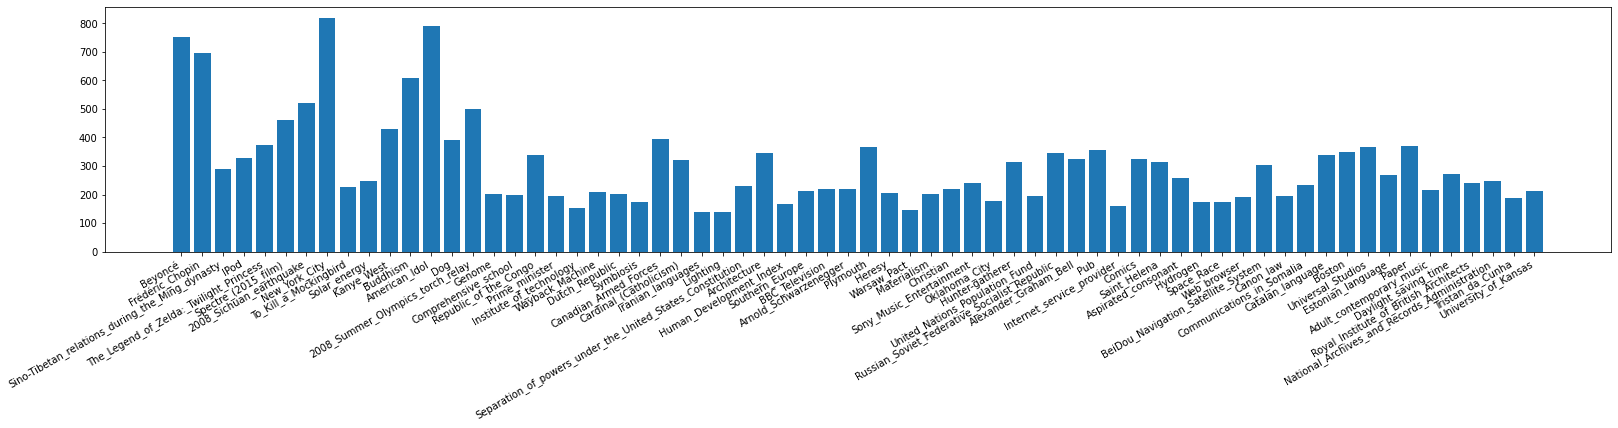

In [7]:
fig, ax1 = plt.subplots(figsize = (27, 5))
plt.bar(counter_squad.keys(), counter_squad.values())
fig.autofmt_xdate()

### Min max values

In [8]:
min(counter_squad, key=counter_squad.get), counter_squad[min(counter_squad, key=counter_squad.get)]

('Iranian_languages', 140)

In [9]:
max(counter_squad, key=counter_squad.get), counter_squad[max(counter_squad, key=counter_squad.get)]

('New_York_City', 817)

Le dataset n'est pas très équilibré entre les classes.

### Mean value

In [10]:
np.array(list(counter_squad.values())).mean()

303.030303030303

### Min Max length of contextes

In [11]:
min_length : str = min(datasets["train"]["context"], key=len)
max_length : str = max(datasets["train"]["context"], key=len)

In [12]:
min_length, len(min_length)

('In the past, the Malays used to call the Portuguese Serani from the Arabic Nasrani, but the term now refers to the modern Kristang creoles of Malaysia.',
 151)

In [13]:
max_length, len(max_length)

('Critical appraisal of the film was mixed in the United States. In a lukewarm review for RogerEbert.com, Matt Zoller Seitz gave the film 2.5 stars out of 4, describing Spectre as inconsistent and unable to capitalise on its potential. Kenneth Turan, reviewing the film for Los Angeles Times, concluded that Spectre "comes off as exhausted and uninspired". Manohla Dargis of The New York Times panned the film as having "nothing surprising" and sacrificing its originality for the sake of box office returns. Forbes\' Scott Mendelson also heavily criticised the film, denouncing Spectre as "the worst 007 movie in 30 years". Darren Franich of Entertainment Weekly viewed Spectre as "an overreaction to our current blockbuster moment", aspiring "to be a serialized sequel" and proving "itself as a Saga". While noting that "[n]othing that happens in Spectre holds up to even minor logical scrutiny", he had "come not to bury Spectre, but to weirdly praise it. Because the final act of the movie is so 

### Mean Length of contexts

In [14]:
sum(map(len, datasets["train"]["context"])) / len(datasets["train"]["context"])

597.92835

## DBPedia entity dataset

In [15]:
dataset : str = "dbpedia-entity"
url : str = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
data_path = util.download_and_unzip(url, "datasets")
corpus, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")

  0%|          | 0/4635922 [00:00<?, ?it/s]

In [16]:
corpus_items_list : list = list(corpus.items())

In [17]:
len(corpus_items_list)

4635922

In [18]:
corpus_items_list[0]

('<dbpedia:Animalia_(book)>',
 {'text': "Animalia is an illustrated children's book by Graeme Base. It was originally published in 1986, followed by a tenth anniversary edition in 1996, and a 25th anniversary edition in 2012. Over three million copies have been sold.   A special numbered and signed anniversary edition was also published in 1996, with an embossed gold jacket.",
  'title': 'Animalia (book)'})

In [19]:
corpus_items_list_texts = []
for key, elt in corpus_items_list:
    if elt["text"] == ".":
        print("Text is '.' :", key)
    if len(elt["text"]) == 42891:
        print("Max length of a corpus :", key)
    corpus_items_list_texts.append(elt["text"])

Text is '.' : <dbpedia:List_of_television_stations_in_Missouri_(by_channel_number)>
Text is '.' : <dbpedia:Aspartoacylase>
Text is '.' : <dbpedia:List_of_squares_in_Saint_Petersburg>
Text is '.' : <dbpedia:Shermann_Audio>
Text is '.' : <dbpedia:1890_in_New_Zealand>
Max length of a corpus : <dbpedia:Agrilus>
Text is '.' : <dbpedia:Khangarh,_Punjab>
Text is '.' : <dbpedia:Carolyne_Aquino>
Text is '.' : <dbpedia:List_of_schools_in_Kolkata>


### Min Max length of contextes

In [20]:
min_length = min(corpus_items_list_texts, key=len)
max_length = max(corpus_items_list_texts, key=len)

In [21]:
min_length, len(min_length)

('.', 1)

In [22]:
max_length, len(max_length)

('Agrilus is a genus of jewel beetles, notable for having the largest number of species (about 3000) of any single genus in the animal kingdom.Species: Agrilus abantiades Descarpentries & Villiers, 1963 Agrilus abditus Horn, 1891 Agrilus abdominalis Saunders, 1874 Agrilus abductus Horn, 1891 Agrilus abeillei (Théry, 1905) Agrilus aberlenci Curletti, 1997 Agrilus aberrans Kerremans, 1900 Agrilus abhayi Baudon, 1965 Agrilus abjectus Horn, 1891 Agrilus abodimanganus Obenberger, 1931 Agrilus aborigines Curletti, 2001 Agrilus abramii Curletti & Dutto, 1999 Agrilus absonus Théry, 1934 Agrilus abstersus Horn, 1891 Agrilus abyssiniae Obenberger, 1935 Agrilus abyssinicus Obenberger, 1917 Agrilus acaciae Fisher, 1928 Agrilus acanthopterus Harold, 1869 Agrilus acastus Kerremans, 1913 Agrilus acceptus Waterhouse, 1889 Agrilus acclivis Waterhouse, 1889 Agrilus acer Curletti, 2006 Agrilus achardi Obenberger, 1935 Agrilus achepei Curletti, 2002 Agrilus achilleus Obenberger, 1935 Agrilus acoloai Fishe

### Mean Length of contexts

In [23]:
sum(map(len, corpus_items_list_texts)) / len(corpus_items_list_texts)

289.4271674544999